<a href="https://colab.research.google.com/github/aenorhabditis6/test/blob/main/Brain_Tumor_Detection_And_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np# linear algebra
np.random.seed(1337)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# # # **IMPORTING LIBRARIES**

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import pathlib
import cv2
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# # **PREPARING DATASET**

In [29]:
ls

'Brain Tumor Detection And Classification Using CNN.ipynb'   Dataset/   LICENSE   README.md


In [38]:
ls

brain_tumor_dataset/  classification_dataset/


In [4]:
import pathlib

# Use the correctly resolved absolute path
path_data = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset")

print(path_data.exists())
print(path_data.is_dir())


True
True


In [5]:
import pathlib

# Corrected absolute paths
path_test = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/testing")
path_data = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/training")

# Print to verify paths
print("Training Path Exists:", path_data.exists())
print("Testing Path Exists:", path_test.exists())

# Count images
image_count = len(list(path_data.glob('*/*.jpg')))
test_image_count = len(list(path_test.glob('*/*.jpg')))

# Print results
print("Training Images Count:", image_count)
print("Testing Images Count:", test_image_count)


Training Path Exists: True
Testing Path Exists: True
Training Images Count: 2870
Testing Images Count: 394


**MRI With a Tumor**

/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/training/glioma_tumor/gg (77).jpg


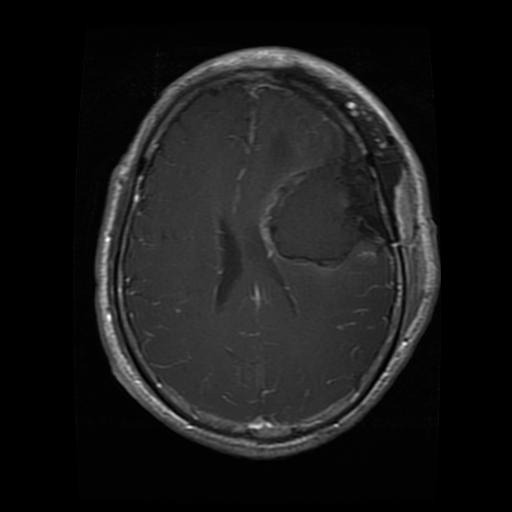

In [6]:
tumors = list(path_data.glob('glioma_tumor/*'))
print(tumors[1])
img1 = PIL.Image.open(str(tumors[0]))
img1

**MRI Without a Tumor**

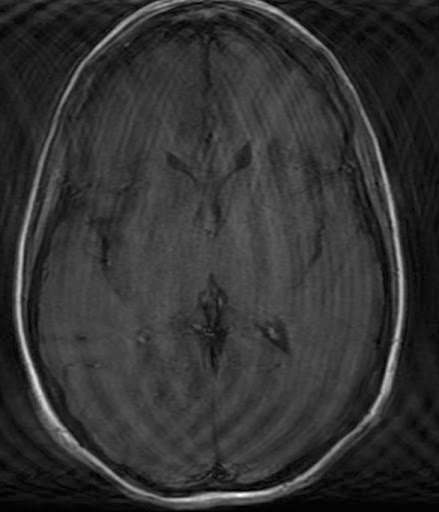

In [7]:
not_tumors = list(path_data.glob('no_tumor/*'))
img2 = PIL.Image.open(str(not_tumors[0]))
img2

In [8]:
img_opencv = cv2.imread(str(not_tumors[0]))
print(img_opencv.shape)
img_opencv1 = cv2.imread(str(tumors[0]))
print(img_opencv1.shape)

(512, 439, 3)
(512, 512, 3)


**Creating Testing and Validation Sets**

In [9]:
batch = 32
img_height = 250
img_width = 250

In [10]:
train = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'training',
seed = 42,
image_size  =(img_height,img_width),
batch_size = batch)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [11]:
val = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'validation',
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [12]:
test = tf.keras.preprocessing.image_dataset_from_directory(
path_test,
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)


Found 394 files belonging to 4 classes.


In [13]:
print(train.class_names)
print(val.class_names)
print(test.class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


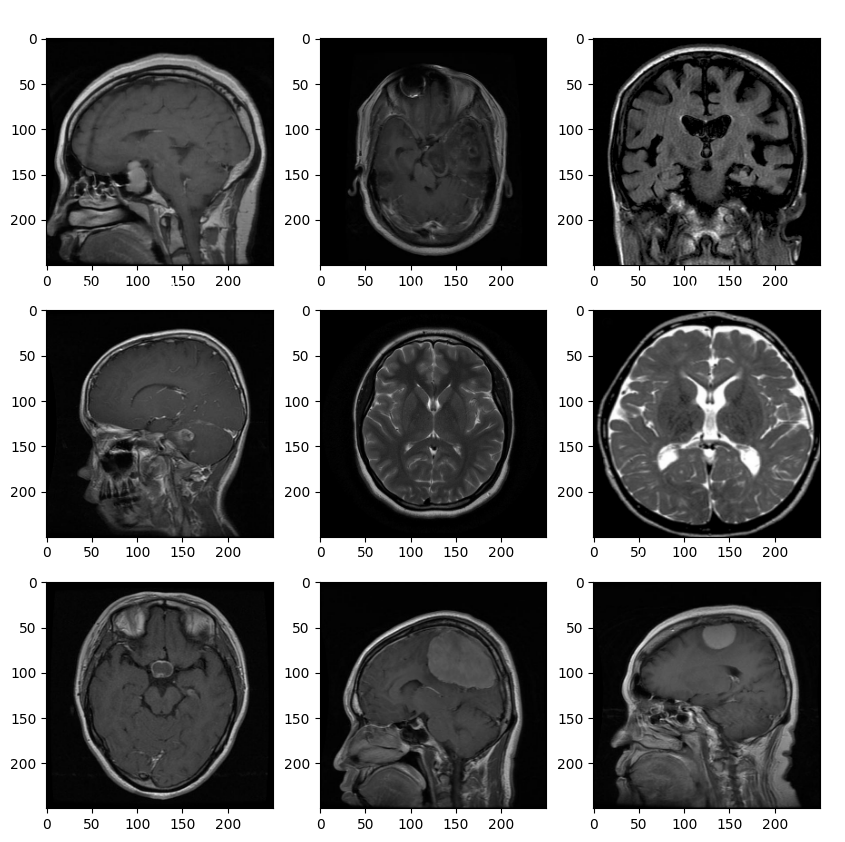

In [14]:
classes = train.class_names
plt.figure(figsize = (10,10))
for img,label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(classes[label[i]],
                  fontdict = {'fontsize': '19',
                              'color': 'white'}
                 )

In [15]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

In [17]:
#testing code library
help(test.as_numpy_iterator())

Help on NumpyIterator in module tensorflow.python.data.ops.dataset_ops object:

class NumpyIterator(tensorflow.python.trackable.base.Trackable)
 |  NumpyIterator(dataset)
 |  
 |  Iterator over a dataset with elements converted to numpy.
 |  
 |  Method resolution order:
 |      NumpyIterator
 |      tensorflow.python.trackable.base.Trackable
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dataset)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  next(self)
 |  
 |  restore(self, state)
 |  
 |  save(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from tensorflow.python.trackable.base.Trackable:
 |  
 |  __dict__
 |      dictionary for instance variables
 |  
 |  __weakref__
 |      list of weak references to the object



# # **IMPORTANT FUNCTIONS**

Prediction of Labels

In [18]:
def prediction_label_comparison(model,test):
    #Retrieve a batch of images from the test set
    image_batch, label_batch = test.as_numpy_iterator().next()
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        predict.append(pred)
    predict = np.array(predict)

    #print('Predictions:\n',predictions)#.numpy())
    print('Labels:\n', label_batch)
    print('Predictions:\n',predict)
    '''
    print(predictions.shape)
    print(label_batch.shape)
    print(predict.shape)
    '''

    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(classes[predict[i]],fontdict = {'fontsize': '14',
                                  'color': 'white'})
      plt.axis("off")
    return label_batch , predict

Test for Tumor

In [19]:
def test_tumor(list_test_path,model):
    # sunflower_url = 'https://'
    # sunflower_path = tf.keras.utils.get_file('name of file', origin=sunflower_url)
    for path_name in list_test_path:
        test_img_path = path_name


        test_image = tf.keras.preprocessing.image.load_img(
            test_img_path, target_size=(img_height, img_width)
        )
        test_array = tf.keras.preprocessing.image.img_to_array(test_image)
        test_array = tf.expand_dims(test_array, 0) # Create a batch

        predictions = model.predict(test_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[np.argmax(score)], 100 * np.max(score))
        )

CSV Builder

In [20]:
def csv_builder(path_data,label_names):
    df = pd.DataFrame(columns = ['images','labels'])
    for name in label_names:
        BASE_DIR = str(path_data)+'/'
        #train_folder_glioma = BASE_DIR+'glioma_tumor/'
        train_folder_name = BASE_DIR+name+'/'

        #train_annotation = BASE_DIR+'annotated_train_data/'

        files_in_train = sorted(os.listdir(train_folder_name))
        #files_in_annotated = sorted(os.listdir(train_annotation))

        image_names =[i for i in files_in_train]


        for x in image_names:
            df = df.append({'images':train_folder_name+str(x),'labels':name},ignore_index=True)
            #df = df.append({'images':str(x),'labels':name},ignore_index=True)

        #df['images']=[train_folder_glioma+str(x) for x in image_names]
        #df['labels']=[train_annotation+str(x) for x in images]
        #pd.to_csv('files_path.csv', header=None)
    return df

Model Input

In [21]:
def model_inputs(model,train,val,test):
    num_classes = 4
    epochs = 15
    model.fit(
        train,
        validation_data=val,
        epochs=epochs,
        #callbacks = callback,
        shuffle=False,
        verbose = 0
    )
    results = model.evaluate(test)
    return results[0],results[1] , model

Cross Validation

In [22]:
def cross_validation(n_splits,final_csv,test_csv,img_width,img_height,model):
    final_loss = 0
    final_acc = 0

    '''
    Seperating a dataframe for testing data
    '''
    ##
    final_csv = final_csv.sample(frac=1)
    ##
    Y = final_csv[['labels']]
    n = len(Y)
    kf = KFold(n_splits = 5)
    #skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
    idg = ImageDataGenerator(#width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.3,
#                          fill_mode='nearest',
#                          horizontal_flip = True,
                         rescale=1./255)




    print('Performing cross validation...')
    test = idg.flow_from_dataframe(test_csv,
                                       x_col = "images",
                                       y_col = "labels",
                                       class_mode = "sparse",
                                       shuffle = True,
                                      target_size = (img_width,img_height),
                                      verbose = 0)#,subset='validation')
#     test = tf.keras.preprocessing.image_dataset_from_directory(path_test,
#                                                                    seed = 42,
#                                                                    image_size = (img_height,img_width),
#                                                                    batch_size = 32)

    for train_index, val_index in kf.split(np.zeros(n),Y):
        training_data = final_csv.iloc[train_index]
        validation_data = final_csv.iloc[val_index]
        train = idg.flow_from_dataframe(training_data,
                                        x_col = "images",
                                        y_col = "labels",
                                        class_mode = "sparse",
                                        shuffle = True,
                                        subset='training',
                                       target_size = (img_width,img_height),
                                       verbose = 0)
        val = idg.flow_from_dataframe(validation_data,
                                      x_col = "images",
                                      y_col = "labels",
                                      class_mode = "sparse",
                                      shuffle = True,
                                     target_size = (img_width,img_height),
                                     verbose = 0)

#         if pretrained == 1:
#             # Create the base model from the pre-trained model MobileNet V2
#             image_size = (img_width,img_height)
#             IMG_SHAPE = image_size + (3,)
#             base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                            include_top=False,
#                                                            weights='imagenet')

#             base_model.trainable = False
#             ##
#             image_batch, label_batch = next(iter(train))
#             feature_batch = base_model(image_batch)
#             print(feature_batch.shape)
#             ##
#             global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#             feature_batch_average = global_average_layer(feature_batch)
#             ##
#             prediction_layer = tf.keras.layers.Dense(4)
#             prediction_batch = prediction_layer(feature_batch_average)
#             ##
#             preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#             ##
#             inputs = tf.keras.Input(shape=(250, 250, 3))
#             #x = data_augmentation(inputs)
#             x = preprocess_input(inputs)
#             x = base_model(x, training=False)
#             x = global_average_layer(x)
#             x = tf.keras.layers.Dropout(0.2)(x)
#             x = tf.keras.layers.Flatten()(x)
#             x = tf.keras.layers.Dense(1280,activation='relu')(x)
#             outputs = prediction_layer(x)
#             model = tf.keras.Model(inputs, outputs)
#             ##
#             base_learning_rate = 0.0001
#             model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                           metrics=['accuracy'])
#             ##


        '''
        Passing the preprocessed data for model training
        '''
        loss,acc,returned_model = model_inputs(model,train,val,test)
        final_loss += loss
        final_acc += acc
    return final_loss/n_splits , final_acc/n_splits , returned_model

DEFINE DIFFERENT LAYERS

In [23]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
conv_layer_32 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
conv_layer_64 = tf.keras.layers.Conv2D(64,3,activation='relu')
conv_layer_16 = tf.keras.layers.Conv2D(16,3,activation='relu')
max_pool = tf.keras.layers.MaxPooling2D()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

DATA AUGMENTATION(PREPROCESSING)

In [24]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1),
    # If you need rotation, uncomment the next line
    # tf.keras.layers.RandomRotation(0.1),
])


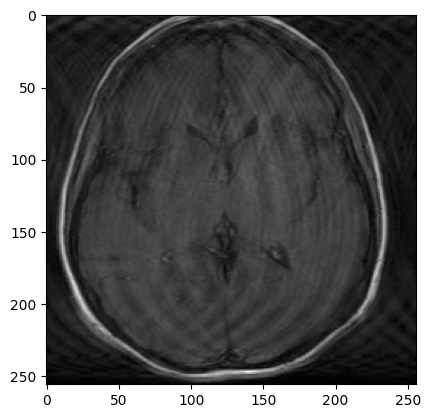

In [25]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    normalization_layer
])

result = resize_and_rescale(img_opencv)
_ = plt.imshow(result)

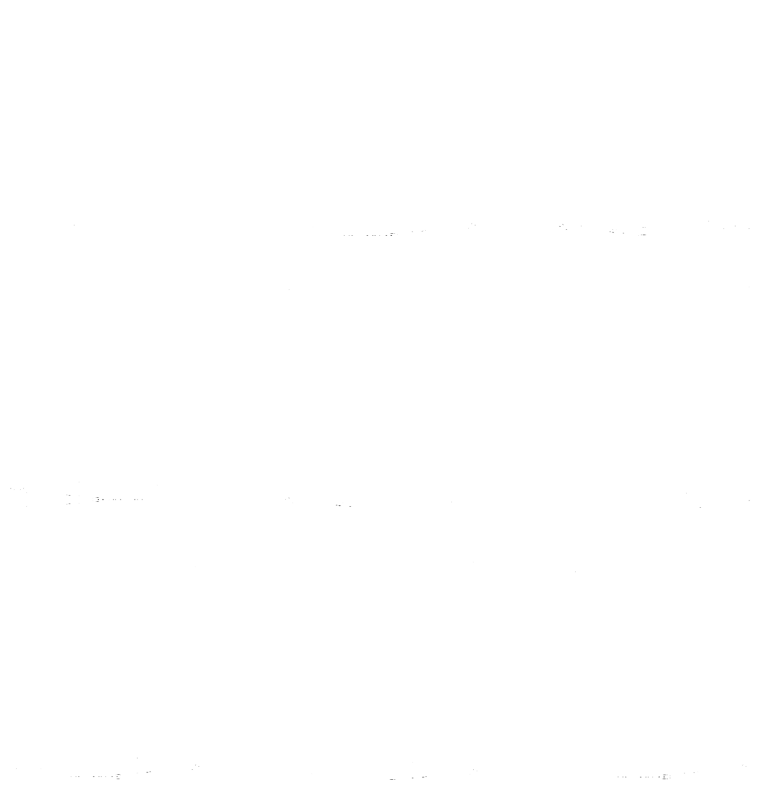

In [28]:
plt.figure(figsize=(10, 10))
img_array = tf.keras.preprocessing.image.img_to_array(img_opencv)
img_array = tf.expand_dims(img_array,0)
for i in range(9):
  augmented_image = data_augmentation(img_array)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# # **MODEL BUILDING**

In [29]:
num_classes = 4

model = tf.keras.Sequential([
  #data_augmentation,
  normalization_layer,
  #tf.keras.layers.Conv2D(32,3,activation='relu'),
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32,(3,3),activation='tanh'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32,(3,3),activation='elu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='elu'),
  layers.Dense(128, activation='tanh'),
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='elu'),
  layers.Dense(64, activation='tanh'),
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='elu'),
  layers.Dense(32, activation='tanh'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='sigmoid')
])

In [30]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [31]:
history = model.fit(
    train,
    validation_data=val,
    epochs= 5,
    callbacks = callback,
    shuffle=False
)
eff_epochs = len(history.history['loss'])

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.4145 - loss: 1.2419 - val_accuracy: 0.6150 - val_loss: 0.8421
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - accuracy: 0.6931 - loss: 0.7294 - val_accuracy: 0.7613 - val_loss: 0.5764
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7695 - loss: 0.5424 - val_accuracy: 0.7404 - val_loss: 0.6578
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8482 - loss: 0.4157 - val_accuracy: 0.7213 - val_loss: 0.8443
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8923 - loss: 0.3049 - val_accuracy: 0.8432 - val_loss: 0.5031


In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 122, 122, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 59, 59, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 26912)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,444,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,554,542 (40.26 MB)

 Trainable params: 3,518,180 (13.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,036,362 (26.84 MB)

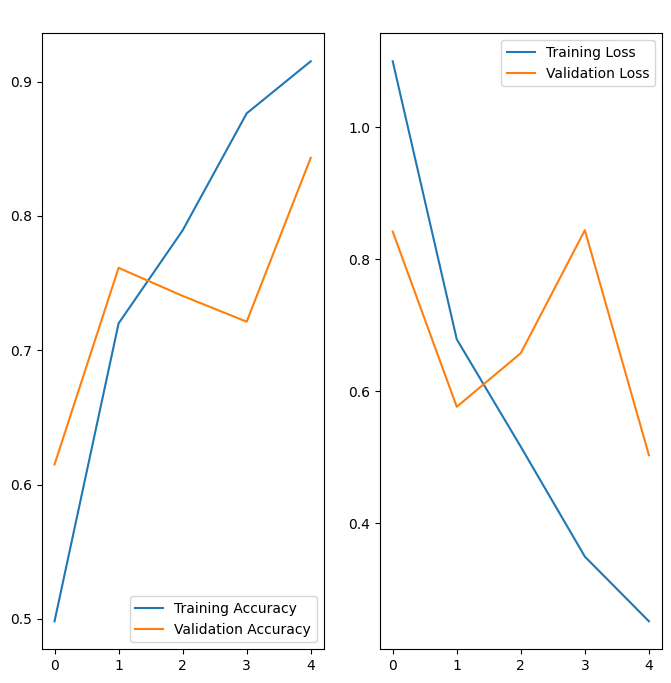

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

In [34]:
results = model.evaluate(test)
print("test loss, test acc:", results)

13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5577 - loss: 1.7794
test loss, test acc: [1.8166794776916504, 0.5482233762741089]


In [42]:
ls /content/drive/MyDrive/Colab\ Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/

brain_tumor_dataset/  classification_dataset/


In [46]:
list_of_paths = ['/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/testing/pituitary_tumor/image(20).jpg',
                '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/testing/no_tumor/image(11).jpg',
                '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/testing/meningioma_tumor/image(120).jpg',
                '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/testing/glioma_tumor/image(16).jpg',
                '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/brain_tumor_dataset/yes/Y100.JPG']
test_tumor(list_of_paths,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to glioma_tumor with a 35.45 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to no_tumor with a 38.78 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to meningioma_tumor with a 36.58 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This image most likely belongs to no_tumor with a 39.11 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to no_tumor with a 39.04 percent confidence.


In [47]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test.as_numpy_iterator():
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
#im.show(image_batch)
print(pred_entire)
print(labels_entire)

[2 2 1 0 2 2 1 2 1 1 2 2 1 2 1 0 2 2 2 0 1 2 1 2 2 2 1 2 1 3 2 2 2 2 2 3 3
 2 1 2 2 2 1 0 2 0 3 2 2 1 2 2 2 1 0 1 2 2 1 1 2 2 2 2 2 3 2 2 2 2 1 1 2 0
 2 0 2 2 3 2 1 1 1 1 1 1 1 2 2 2 2 1 3 2 2 2 1 1 3 2 2 3 1 1 2 1 2 3 0 2 0
 2 2 3 3 2 2 1 2 2 2 2 2 2 1 2 1 2 1 1 2 1 2 2 1 2 0 1 2 2 1 1 2 0 2 2 2 0
 2 1 2 0 2 2 1 1 2 2 2 1 2 2 2 2 1 2 2 2 1 1 2 2 2 2 2 2 2 1 3 2 2 2 2 1 3
 1 2 2 2 2 1 2 1 1 2 1 1 2 2 1 2 2 2 1 3 3 2 1 2 1 2 2 1 2 1 1 2 1 1 2 2 1
 2 2 2 0 3 1 2 2 2 1 3 2 2 2 2 2 0 2 1 1 2 2 2 1 2 1 1 1 1 1 1 1 2 2 3 2 1
 1 2 2 0 2 1 2 2 2 1 2 2 2 2 2 3 1 2 2 1 2 2 2 2 2 1 2 1 1 2 1 0 1 2 2 1 2
 2 1 2 2 1 2 2 3 2 2 1 2 1 1 2 2 2 1 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2 2 2 2
 2 2 2 1 1 1 2 1 1 2 2 2 2 0 1 1 2 1 2 2 1 0 2 2 2 2 1 2 2 2 2 2 2 1 2 2 1
 1 1 2 2 2 1 2 3 1 1 2 2 2 3 2 1 2 1 2 2 2 2 1 2]
[2 0 1 0 2 2 1 3 1 1 3 0 2 1 1 0 0 1 0 0 3 3 1 2 2 1 2 2 1 3 3 2 1 2 1 3 3
 0 1 0 2 0 1 0 2 0 3 1 1 1 0 2 0 3 3 3 2 2 1 3 2 2 2 2 2 3 1 2 0 3 0 1 2 0
 1 0 1 1 3 0 1 1 1 1 1 1 3 2 2 1 3 1 3 3 2 1 0 1 3

In [48]:
print(classification_report(labels_entire, pred_entire, target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.17      0.28       100
meningioma_tumor       0.62      0.65      0.64       115
        no_tumor       0.44      0.97      0.61       105
 pituitary_tumor       0.96      0.30      0.45        74

        accuracy                           0.55       394
       macro avg       0.72      0.52      0.50       394
    weighted avg       0.70      0.55      0.51       394



MODEL 2 Default

In [49]:
num_classes = 4

model2 = tf.keras.Sequential([
  normalization_layer,
  conv_layer_32,
  max_pool,
  conv_layer_64,
  max_pool,
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

In [50]:
model2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [51]:
history = model2.fit(
    train,
    validation_data=val,
    epochs= 3,
    callbacks = callback,
    shuffle=False
)
eff_epochs = len(history.history['loss'])

Epoch 1/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.5300 - loss: 1.2069 - val_accuracy: 0.8223 - val_loss: 0.4992
Epoch 2/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8454 - loss: 0.4113 - val_accuracy: 0.8624 - val_loss: 0.4057
Epoch 3/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9297 - loss: 0.2009 - val_accuracy: 0.8868 - val_loss: 0.3158


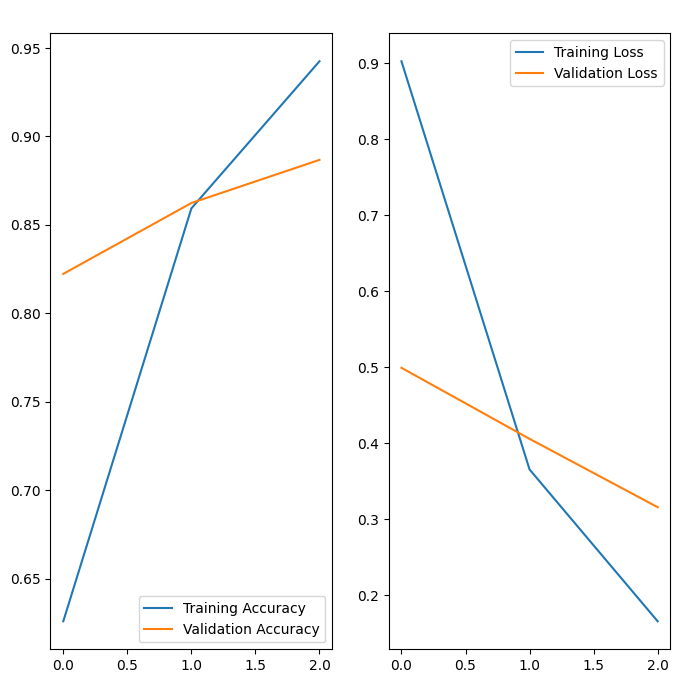

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

In [53]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 238144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │       7,620,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,920,494 (87.43 MB)

 Trainable params: 7,640,164 (29.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,280,330 (58.29 MB)

In [54]:
results = model.evaluate(test)
print("test loss, test acc:", results)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5456 - loss: 1.7869
test loss, test acc: [1.8726775646209717, 0.5329949259757996]


In [57]:
list_of_paths = ['/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/testing/pituitary_tumor/image(20).jpg',
                '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/testing/no_tumor/image(11).jpg',
                '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/testing/meningioma_tumor/image(120).jpg',
                '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/classification_dataset/testing/glioma_tumor/image(16).jpg',
                '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection-And-Classification/Dataset/brain_tumor_dataset/yes/Y100.JPG']
test_tumor(list_of_paths,model2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to pituitary_tumor with a 59.10 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This image most likely belongs to no_tumor with a 88.08 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to meningioma_tumor with a 98.14 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
This image most likely belongs to no_tumor with a 96.12 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This image most likely belongs to no_tumor with a 52.52 percent confidence.


In [58]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test.as_numpy_iterator():
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
#im.show(image_batch)
print(pred_entire)
print(labels_entire)

[2 3 3 1 1 1 2 3 2 2 1 1 2 2 2 3 1 3 0 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2
 0 2 2 2 2 1 2 2 1 1 3 2 2 2 0 2 2 2 3 2 2 2 2 2 2 2 2 2 0 3 2 2 0 1 2 1 0
 1 2 1 1 2 2 1 3 2 1 2 2 2 2 2 2 2 3 0 3 2 2 2 2 3 2 1 2 2 1 2 2 2 2 2 2 1
 2 2 2 3 2 2 2 2 2 2 2 3 2 3 0 2 3 3 1 2 2 2 2 2 2 1 1 2 2 1 2 2 2 1 2 2 0
 2 2 1 1 1 2 2 2 0 1 2 1 1 3 2 2 0 2 2 2 2 1 1 2 2 3 1 2 2 2 2 2 2 2 2 3 1
 2 2 2 2 2 2 2 3 1 2 2 1 2 2 2 2 1 2 1 3 2 2 2 1 1 0 1 1 3 2 1 2 2 2 2 1 2
 0 2 2 1 2 2 1 2 2 1 2 2 2 2 0 3 2 1 2 1 2 1 2 2 2 1 1 2 2 2 2 1 2 2 2 2 2
 2 1 2 3 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 0 2 1 2 1 1 2 1 1 2 0 2 1 1 0 2 2
 1 2 2 1 2 1 2 2 2 2 2 3 0 2 1 2 2 3 2 2 2 1 3 2 2 2 2 2 1 1 2 2 2 2 2 1 1
 2 2 1 1 2 2 2 1 2 2 3 2 2 2 1 2 2 2 2 1 2 2 1 0 2 2 1 3 1 2 2 2 2 2 1 2 2
 2 3 2 2 2 2 1 2 2 1 2 2 1 1 1 2 3 2 3 2 1 2 2 2]
[2 3 3 3 1 1 0 3 0 1 1 1 3 2 3 3 0 3 0 2 0 1 1 1 0 2 3 2 2 2 2 0 3 2 2 1 0
 3 2 2 0 0 1 2 2 1 1 3 0 1 0 0 0 0 3 3 1 2 1 1 2 0 1 1 3 0 3 2 2 0 1 2 1 0
 2 1 1 1 2 1 1 3 2 1 3 2 0 0 1 3 0 3 0 3 0 2 2 1 3

In [59]:
print(classification_report(labels_entire, pred_entire, target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.84      0.16      0.27       100
meningioma_tumor       0.67      0.53      0.59       115
        no_tumor       0.40      0.96      0.57       105
 pituitary_tumor       0.97      0.43      0.60        74

        accuracy                           0.53       394
       macro avg       0.72      0.52      0.51       394
    weighted avg       0.70      0.53      0.50       394

